## Introduction
In this notebook, we analyze the historical and recent patterns of CO₂ emissions across Europe using data from the OWID CO₂ dataset. Our goal is to identify key drivers behind emissions and build a predictive model using machine learning. We adopt FAIR data practices by accessing data through TU Wien's DBRepo API and publishing our results for reproducibility.


## Load Data from DBRepo
I access the train, validation, and test subsets from DBRepo using the REST API via the `RestClient`. This ensures the dataset is versioned, traceable, and reusable.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from dbrepo.RestClient import RestClient

In [2]:
client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at")

df_train = client.get_subset_data(database_id="99116b65-645f-4057-8353-21628a0e52ed", subset_id="a11249d0-1873-11f0-bcdb-ce537b1757c0", size=1000)

df_val = client.get_subset_data(database_id="99116b65-645f-4057-8353-21628a0e52ed", subset_id="31da7372-1874-11f0-a3a8-2ebef9ba1aed", size=1000)

df_test = client.get_subset_data(database_id="99116b65-645f-4057-8353-21628a0e52ed", subset_id="0a690487-1874-11f0-bcdb-ce537b1757c0", size=1000)

### Understand the structure of each subset

In [28]:
df_train.info()
df_val.info()
df_test.info()

# Check missing values
print("Missing values (train):")
print(df_train.isnull().sum().sort_values(ascending=False).head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 199 to 999
Data columns (total 80 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   row_id                                     518 non-null    object 
 1   country                                    518 non-null    object 
 2   year                                       518 non-null    int64  
 3   iso_code                                   204 non-null    object 
 4   population                                 344 non-null    float64
 5   gdp                                        150 non-null    float64
 6   cement_co2                                 332 non-null    float64
 7   cement_co2_per_capita                      332 non-null    float64
 8   co2                                        518 non-null    float64
 9   co2_growth_abs                             340 non-null    float64
 10  co2_growth_prct              

## Data Cleaning and Preparation
I convert all selected features and the target `co2` to numeric format. Missing values are handled using mean imputation. Rows with missing target values are dropped to ensure training quality.

In [29]:
import pandas as pd

features = ['year', 'population', 'gdp', 'cement_co2', 
            'cement_co2_per_capita', 'co2_growth_abs', 'co2_growth_prct']
target = 'co2'

# Convert selected features and target to numeric
for col in features + [target]:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
    df_val[col] = pd.to_numeric(df_val[col], errors='coerce')
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

# Fill missing values in features
for col in features:
    df_train[col] = df_train[col].fillna(df_train[col].mean())
    df_val[col] = df_val[col].fillna(df_val[col].mean())
    df_test[col] = df_test[col].fillna(df_test[col].mean())

# Drop rows where target is missing
df_train = df_train.dropna(subset=[target])
df_val = df_val.dropna(subset=[target])
df_test = df_test.dropna(subset=[target])

## Feature & Target Split

In [30]:
X_train = df_train[features]
y_train = df_train[target]

X_val = df_val[features]
y_val = df_val[target]

X_test = df_test[features]
y_test = df_test[target]

## Model Training
A Random Forest Regressor is trained on the selected features to predict CO₂ emissions. We use scikit-learn's implementation with 100 trees and a fixed random state for reproducibility.

In [31]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Evaluation
I compute RMSE and R² scores on the validation and test sets to assess the model’s performance. A large gap between validation and test may indicate overfitting or test set anomalies.

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# RMSE calculated manually using np.sqrt(MSE)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# R² scores
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

# Print results
print("Validation RMSE:", rmse_val)
print("Validation R²:", r2_val)
print()
print("Test RMSE:", rmse_test)
print("Test R²:", r2_test)

Validation RMSE: 4905.442347482011
Validation R²: -0.045472381090293945

Test RMSE: 3624.88762133803
Test R²: 0.05893818698594877


## Visualization and Interpretability
I plot feature importances and actual vs predicted CO₂ values. These visual tools help us understand which variables contribute most to emission levels and how well the model performs across different ranges.

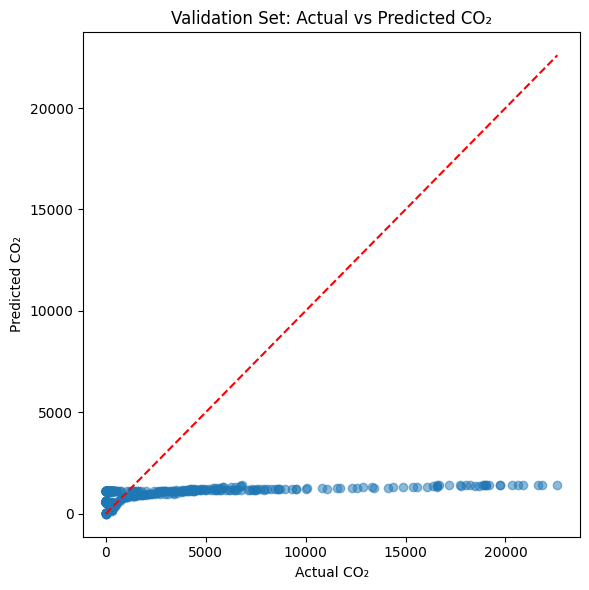

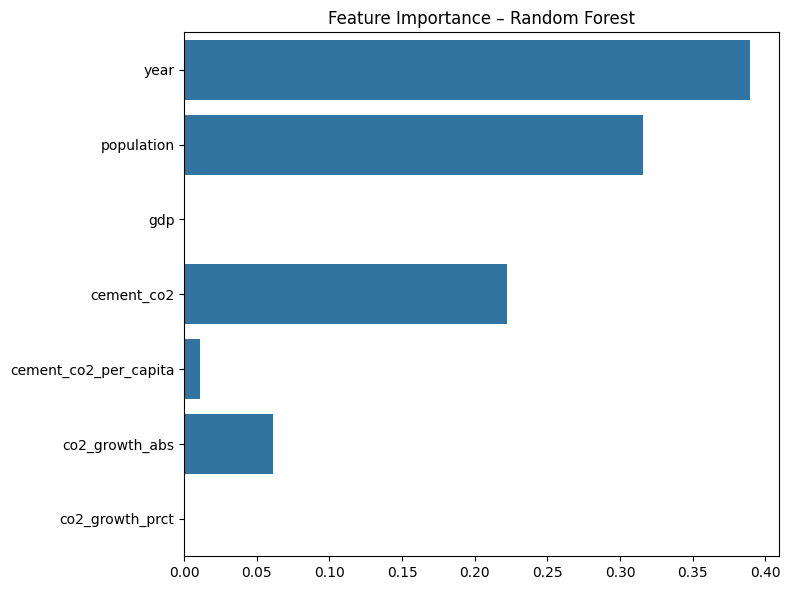

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual CO₂")
plt.ylabel("Predicted CO₂")
plt.title("Validation Set: Actual vs Predicted CO₂")
plt.tight_layout()
plt.show()

# Feature Importance
plt.figure(figsize=(8,6))
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance – Random Forest")
plt.tight_layout()
plt.show()

## Output Storage
The trained model, prediction results, and plots are saved as output files. These can be uploaded to TUWRD with FAIR metadata for future reuse.

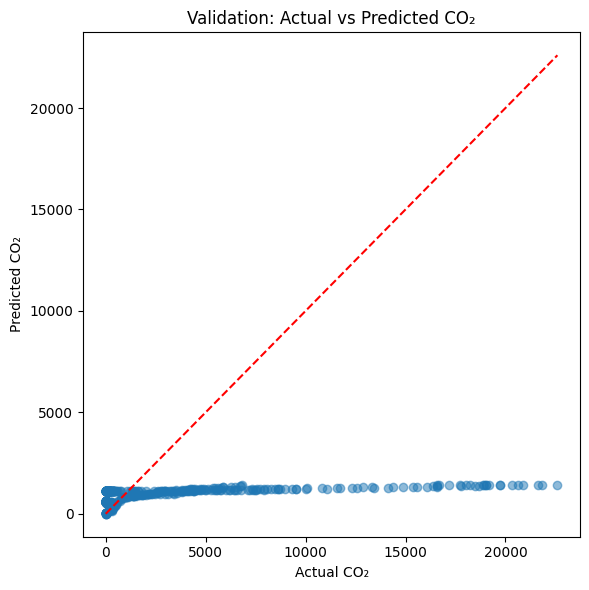

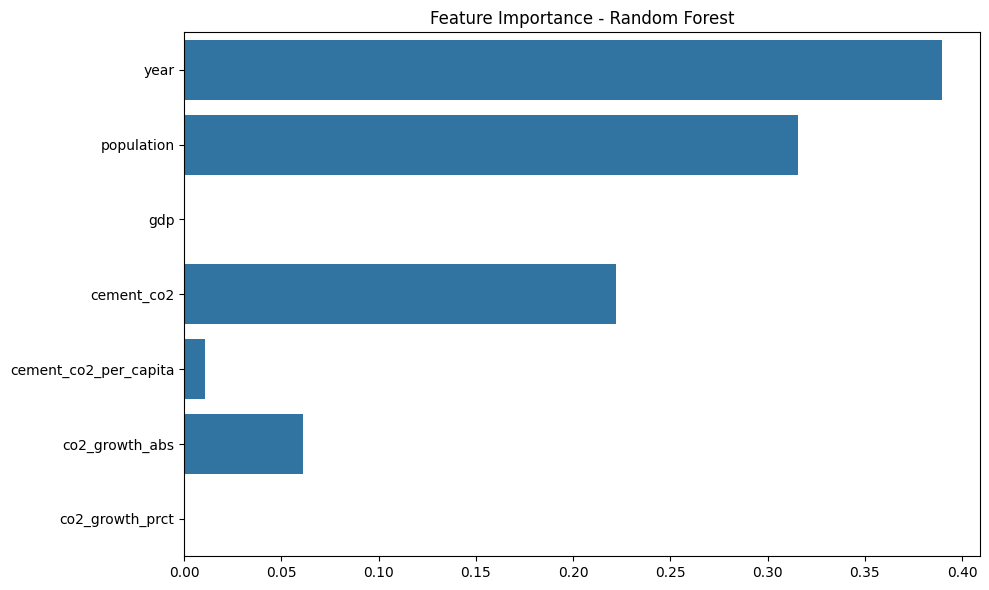

In [35]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 🎯 Save the trained model
joblib.dump(model, "rf_model.joblib")

# 🎯 Save validation and test predictions
val_results = pd.DataFrame({
    "y_true": y_val,
    "y_pred": y_pred_val
})
val_results.to_csv("validation_predictions.csv", index=False)

test_results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_test
})
test_results.to_csv("test_predictions.csv", index=False)

# 🎯 Save actual vs predicted plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual CO₂")
plt.ylabel("Predicted CO₂")
plt.title("Validation: Actual vs Predicted CO₂")
plt.tight_layout()
plt.savefig("val_pred_vs_actual.png")
plt.show()

# 🎯 Save feature importance plot (if not already)
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()